# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import pandas as pd
import torch
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from loguru import logger
logger.remove()  # Remove any default sinks set up automatically

from utils import data_processing, visualization

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import synthcity.logger as log
import sys
import json
import os

log.remove()  # Remove default handlers
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/hivae/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
aids_control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
aids_control = pd.read_csv(data_file_control, header=None, names=aids_control_fnames)
print(aids_control.head())

   time  censor  strat2  sex  raceth  ivdrug  karnof    cd4  priorzdv  age
0   189       0       1    1       1       0     100  169.0      39.0   34
1   287       0       1    2       2       0      90  149.5      15.0   34
2   199       0       1    1       1       0      90   46.0      53.0   48
3   270       0       1    1       2       0     100   54.5       6.0   51
4   276       0       1    1       1       0     100   95.0       7.0   34


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=aids_control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=aids_control_fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)


## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [6]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE" : surv_hivae, 
                   "Surv-GAN" : surv_gan, 
                   "Surv-VAE" : surv_vae}

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Hyperparameters optimization

In [ ]:
name_config = "aids_surv_piecewise"
n_trials = 10 # number of trials for each generator
n_splits = 5 # number of splits for cross-validation
n_generated_samples = 10 # number of generated datasets each time

In [8]:
generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]

best_params_dict, study_dict = {}, {}
for generator_name in generators_sel:
    db_file = "optuna_results/optuna_study_{}_{}.db".format(name_config, generator_name)
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
    else: 
        print("Creating new optuna study for {}...".format(generator_name))
        if generator_name in ["HI-VAE"]:
            T_surv = torch.Tensor(df_init_control.time)
            T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
            n_intervals = 5
            T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
            T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
            intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search((data_init_control_encoded, intervals), 
                                                                                                    data_init_control,
                                                                                                    miss_mask_control, 
                                                                                                    true_miss_mask_control, 
                                                                                                    feat_types_file_control, 
                                                                                                    feat_types_dict, 
                                                                                                    n_generated_sample=n_generated_samples, 
                                                                                                    n_splits=n_splits,
                                                                                                    n_trials=n_trials, 
                                                                                                    columns=aids_control_fnames, 
                                                                                                    study_name="optuna_results/optuna_study_{}_{}".format(name_config, generator_name),)
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "w") as f:
                json.dump(best_params, f)
        else: 
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search(data_init_control, 
                                                                                            columns=aids_control_fnames, 
                                                                                            target_column="censor", 
                                                                                            time_to_event_column="time", 
                                                                                            n_generated_sample=n_generated_samples, 
                                                                                            n_splits=n_splits,
                                                                                            n_trials=n_trials, 
                                                                                            study_name="optuna_results/optuna_study_{}_{}".format(name_config, generator_name),)
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "w") as f:
                json.dump(best_params, f)

   

Creating new optuna study for HI-VAE...
trial_0
Epoch: [ 0]  time: 0.0678, ELBO_train: -22.48705292, KL_z: 2.58931065, KL_s: 0.03916490, reconstruction loss: -19.85857737
Epoch: [100]  time: 4.0399, ELBO_train: -17.77740145, KL_z: 0.60418332, KL_s: 0.07497227, reconstruction loss: -17.09824586
Epoch: [200]  time: 7.5366, ELBO_train: -17.37318373, KL_z: 0.72752734, KL_s: 0.07216755, reconstruction loss: -16.57348885
Epoch: [300]  time: 12.0715, ELBO_train: -17.34649992, KL_z: 0.78902133, KL_s: 0.08114222, reconstruction loss: -16.47633637
Epoch: [400]  time: 16.2195, ELBO_train: -17.31900358, KL_z: 0.85551615, KL_s: 0.09421745, reconstruction loss: -16.36926998
Training finished.
Epoch: [ 0]  time: 0.0246, ELBO_train: -17.21363497, KL_z: 0.86529200, KL_s: 0.09230191, reconstruction loss: -16.25604106
Epoch: [100]  time: 3.2521, ELBO_train: -17.16688395, KL_z: 0.83580084, KL_s: 0.24962094, reconstruction loss: -16.08146216
Epoch: [200]  time: 6.3874, ELBO_train: -17.10349464, KL_z: 0.883

[2025-05-23T16:21:14.511312+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:21:14.512126+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:21:14.512339+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:21:14.512509+0200][39140][CRITICAL] module plugin_decaf load failed


trial_0


[2025-05-23T16:21:15.036225+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:21:15.037329+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:21:15.037727+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:21:15.038245+0200][39140][CRITICAL] module plugin_decaf load failed
  7%|▋         | 749/10000 [00:22<04:36, 33.48it/s]
[2025-05-23T16:21:47.520178+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:21:47.521637+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:21:47.522076+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Score: 0.033624468074934834
trial_1


 17%|█▋        | 1749/10000 [00:52<04:05, 33.54it/s]
[2025-05-23T16:24:42.104773+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:24:42.105624+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:24:42.106096+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:24:42.106435+0200][39140][CRITICAL] module plugin_decaf load failed
  6%|▌         | 599/10000 [00:13<03:39, 42.88it/s]
[2025-05-23T16:25:02.773395+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:25:02.774657+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:25:02.774979+0200][39140][CRITICAL] load failed: mo

Score: 0.034814642367532934
trial_2


  4%|▍         | 449/10000 [00:15<05:21, 29.75it/s]
[2025-05-23T16:58:59.325837+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:58:59.330902+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:58:59.331374+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:58:59.331616+0200][39140][CRITICAL] module plugin_decaf load failed
  3%|▎         | 349/10000 [00:11<05:18, 30.34it/s]
[2025-05-23T16:59:19.774792+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T16:59:19.776464+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T16:59:19.776827+0200][39140][CRITICAL] load failed: mod

Score: 0.19287686990384798
trial_3


  9%|▉         | 949/10000 [00:35<05:38, 26.71it/s]
[2025-05-23T17:16:00.508570+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T17:16:00.509545+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:16:00.509901+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:16:00.510202+0200][39140][CRITICAL] module plugin_decaf load failed
 10%|▉         | 999/10000 [00:40<06:03, 24.79it/s]
[2025-05-23T17:33:40.085922+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T17:33:40.088008+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:33:40.088435+0200][39140][CRITICAL] load failed: mod

Score: 0.1367222858165863
trial_4


  4%|▍         | 399/10000 [00:08<03:14, 49.28it/s]
[2025-05-23T17:35:31.470830+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T17:35:31.473017+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:35:31.473457+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:35:31.473909+0200][39140][CRITICAL] module plugin_decaf load failed
  6%|▌         | 599/10000 [16:14<4:14:51,  1.63s/it]  
[2025-05-23T17:51:53.339610+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T17:51:53.341008+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:51:53.341507+0200][39140][CRITICAL] load failed:

Score: 0.023978264362125298
trial_5


  3%|▎         | 299/10000 [00:06<03:44, 43.12it/s]
[2025-05-23T17:53:13.150135+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T17:53:13.150968+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:53:13.151369+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:53:13.151657+0200][39140][CRITICAL] module plugin_decaf load failed
  3%|▎         | 299/10000 [00:06<03:43, 43.34it/s]
[2025-05-23T17:53:43.864510+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T17:53:43.866219+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T17:53:43.866713+0200][39140][CRITICAL] load failed: mod

Score: 0.2391734345638624
trial_6


  5%|▌         | 549/10000 [00:17<04:54, 32.14it/s]
[2025-05-23T18:18:07.540598+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T18:18:07.541675+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:18:07.542137+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:18:07.542462+0200][39140][CRITICAL] module plugin_decaf load failed
  5%|▌         | 549/10000 [01:35<27:29,  5.73it/s]   
[2025-05-23T18:19:49.428068+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T18:19:49.428951+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:19:49.429238+0200][39140][CRITICAL] load failed: 

Score: 0.2036756169774525
trial_7


  8%|▊         | 849/10000 [00:25<04:30, 33.85it/s]
[2025-05-23T18:38:13.962113+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T18:38:13.963287+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:38:13.963622+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:38:13.963939+0200][39140][CRITICAL] module plugin_decaf load failed
 11%|█▏        | 1149/10000 [00:32<04:10, 35.37it/s]
[2025-05-23T18:38:54.579019+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T18:38:54.580394+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:38:54.580848+0200][39140][CRITICAL] load failed: mo

Score: 0.03407642929477912
trial_8


 12%|█▏        | 1199/10000 [00:32<03:58, 36.83it/s]
[2025-05-23T18:54:16.833173+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T18:54:16.834873+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:54:16.835216+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:54:16.835541+0200][39140][CRITICAL] module plugin_decaf load failed
  6%|▋         | 649/10000 [00:17<04:16, 36.42it/s]
[2025-05-23T18:54:42.390538+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T18:54:42.391678+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T18:54:42.392266+0200][39140][CRITICAL] load failed: mo

Score: 0.03971682446504352
trial_9


  4%|▍         | 399/10000 [15:44<6:18:49,  2.37s/it] 
[2025-05-23T19:19:51.532663+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T19:19:51.533614+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:19:51.533872+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:19:51.534132+0200][39140][CRITICAL] module plugin_decaf load failed
  8%|▊         | 849/10000 [00:12<02:19, 65.42it/s]
[2025-05-23T19:20:11.293180+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T19:20:11.294249+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:20:11.294599+0200][39140][CRITICAL] load failed: 

Score: 0.027482208027335763
Creating new optuna study for Surv-VAE...
trial_0


100%|██████████| 100/100 [00:01<00:00, 52.20it/s]
[2025-05-23T19:21:20.784551+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T19:21:20.785467+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:21:20.785817+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:21:20.786352+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:01<00:00, 59.73it/s]
[2025-05-23T19:21:31.622285+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T19:21:31.622987+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:21:31.623286+0200][39140][CRITICAL] load failed: module 

Score: 0.29905792774699735
trial_1


100%|██████████| 100/100 [16:02<00:00,  9.62s/it]  
[2025-05-23T19:53:59.855027+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T19:53:59.856442+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:53:59.857090+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:53:59.857588+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:42<00:00,  2.38it/s]
[2025-05-23T19:54:49.572865+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T19:54:49.573585+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T19:54:49.573803+0200][39140][CRITICAL] load failed: modul

Score: 0.05229332431991631
trial_2


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]
[2025-05-24T09:27:53.499171+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T09:27:53.500235+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T09:27:53.500412+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T09:27:53.500566+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [1:17:13<00:00, 46.33s/it]  
[2025-05-24T10:45:12.505707+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:45:12.506783+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:45:12.506959+0200][39140][CRITICAL] load failed: mod

Score: 0.05935603718547703
trial_3


100%|██████████| 100/100 [00:02<00:00, 42.32it/s]
[2025-05-24T10:58:35.151496+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:58:35.153250+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:58:35.153598+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:58:35.153811+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:01<00:00, 56.21it/s]
[2025-05-24T10:58:42.741067+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:58:42.742958+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:58:42.743268+0200][39140][CRITICAL] load failed: module 

Score: 0.18785057032115618
trial_4


100%|██████████| 100/100 [00:00<00:00, 141.10it/s]
[2025-05-24T10:59:14.402605+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:59:14.403974+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:59:14.404172+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:59:14.404443+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:00<00:00, 115.82it/s]
[2025-05-24T10:59:20.966288+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:59:20.967487+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:59:20.967713+0200][39140][CRITICAL] load failed: modul

Score: 0.04025149985369698
trial_5


100%|██████████| 100/100 [00:02<00:00, 44.60it/s]
[2025-05-24T10:59:49.895240+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:59:49.896147+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:59:49.896348+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:59:49.896545+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:01<00:00, 60.31it/s]
[2025-05-24T10:59:57.045761+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T10:59:57.046216+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T10:59:57.046429+0200][39140][CRITICAL] load failed: module 

Score: 0.03889396879960534
trial_6


100%|██████████| 100/100 [00:06<00:00, 15.18it/s]
[2025-05-24T11:00:32.932899+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:00:32.933687+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:00:32.933860+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:00:32.934041+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:06<00:00, 14.44it/s]
[2025-05-24T11:00:45.547987+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:00:45.550293+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:00:45.551186+0200][39140][CRITICAL] load failed: module 

Score: 0.05737019860812551
trial_7


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]
[2025-05-24T11:01:43.124981+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:01:43.126248+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:01:43.126493+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:01:43.126675+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:13<00:00,  7.30it/s]
[2025-05-24T11:02:02.759510+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:02:02.760563+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:02:02.760740+0200][39140][CRITICAL] load failed: module 

Score: 0.03587896709497337
trial_8


100%|██████████| 100/100 [00:03<00:00, 28.13it/s]
[2025-05-24T11:03:12.552774+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:03:12.554349+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:03:12.554609+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:03:12.554825+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:03<00:00, 27.93it/s]
[2025-05-24T11:03:21.870983+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:03:21.871616+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:03:21.871786+0200][39140][CRITICAL] load failed: module 

Score: 0.05416091058727438
trial_9


100%|██████████| 100/100 [00:11<00:00,  8.81it/s]
[2025-05-24T11:04:06.567602+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:04:06.567996+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:04:06.568150+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:04:06.568337+0200][39140][CRITICAL] module plugin_decaf load failed
100%|██████████| 100/100 [00:11<00:00,  8.97it/s]
[2025-05-24T11:04:23.598573+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:04:23.599236+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:04:23.599446+0200][39140][CRITICAL] load failed: module 

Score: 0.06359078452464402


### Visualization of one study

In [9]:
generator_name = "HI-VAE" # Choose between "HI-VAE", "Surv-GAN", "Surv-VAE"

# study = study_dict[generator_name] 
# best_params = best_params_dict[generator_name]

with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "r") as f:
    best_params = json.load(f)
print(best_params)
study_name = "optuna_results/optuna_study_{}_{}".format(name_config, generator_name)
study = optuna.load_study(study_name=study_name, storage="sqlite:///"+study_name+".db")

{'n_layers_surv_piecewise': 1, 'lr': 0.0002, 'batch_size': 64, 'z_dim': 10, 'y_dim': 15, 's_dim': 5}


In [10]:
plot_optimization_history(study)

In [11]:
# Visualize high-dimensional parameter relationships. 
plot_parallel_coordinate(study)

In [12]:
# Visualize hyperparameter relationships.
fig = plot_contour(study, params=list(best_params.keys()))
fig.update_layout(width=800, height=800)

In [13]:
# Visualize individual hyperparameters as slice plot.
plot_slice(study)

In [14]:
# Visualize parameter importances.
plot_param_importances(study)

In [15]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [16]:
# Visualize empirical distribution function of the objective.
plot_edf(study)

### Generation with best parameters

In [17]:
# the datasets used for training is data_init_control
n_generated_dataset = 100

T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "r") as f:
        best_params = json.load(f)
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE"]:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run((data_init_control_encoded, intervals), miss_mask_control, true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset, params=best_params)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=aids_control_fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_dataset, params=best_params)

Generate data by HI-VAE
Epoch: [ 0]  time: 0.1166, ELBO_train: -21.38756299, KL_z: 1.39211363, KL_s: 0.06924586, reconstruction loss: -19.92620350
Epoch: [100]  time: 3.9746, ELBO_train: -18.56948352, KL_z: 0.47179049, KL_s: 0.04230353, reconstruction loss: -18.05538950
Epoch: [200]  time: 7.7671, ELBO_train: -17.57668519, KL_z: 0.58981910, KL_s: 0.04438575, reconstruction loss: -16.94248035
Epoch: [300]  time: 11.4820, ELBO_train: -17.36677313, KL_z: 0.71823028, KL_s: 0.04496202, reconstruction loss: -16.60358083
Epoch: [400]  time: 15.2110, ELBO_train: -17.37563562, KL_z: 0.80208803, KL_s: 0.04645152, reconstruction loss: -16.52709607


[2025-05-24T11:12:02.116208+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:12:02.116999+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:02.117234+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:02.117439+0200][39140][CRITICAL] module plugin_decaf load failed
[2025-05-24T11:12:02.223824+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:12:02.224345+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:02.224587+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:02.224788+0200]

Training finished.
Generate data by Surv-GAN


  6%|▋         | 649/10000 [00:11<02:40, 58.31it/s]
[2025-05-24T11:12:22.903290+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:12:22.904250+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:22.904493+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:22.904703+0200][39140][CRITICAL] module plugin_decaf load failed
[2025-05-24T11:12:22.917488+0200][39140][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:12:22.918300+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-24T11:12:22.918671+0200][39140][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


In [18]:
n_generated_dataset = 100

In [19]:
# Convert generated data into dataframe
df_gen_control_dict = {}
df_syn_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    data_syn = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=aids_control_fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        data_syn.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict[generator_name] = list_df_gen_control
    df_syn_dict[generator_name] = data_syn

### 3. Compare generation performance

#### 3.1. General metrics

In [20]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

##### 3.1.1. Data resemblance

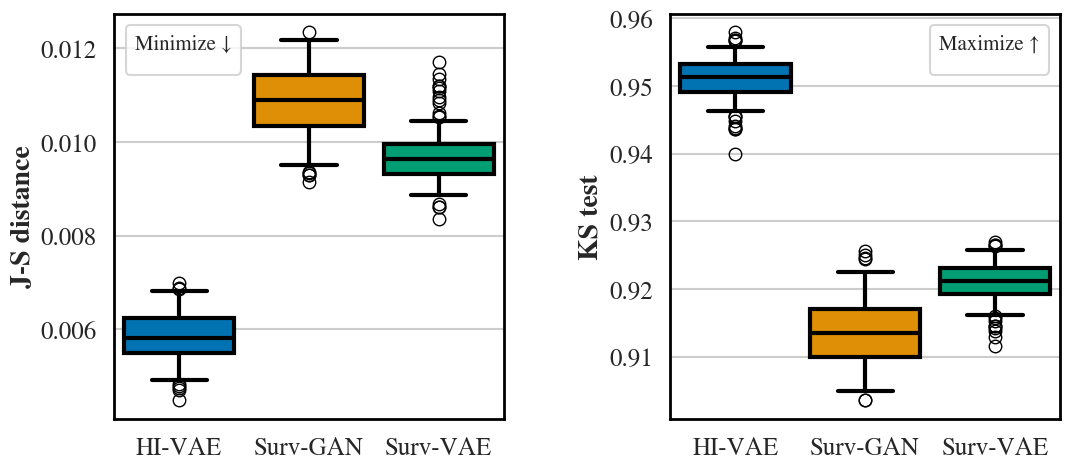

In [21]:
from utils.visualization import visualize_general_perf
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

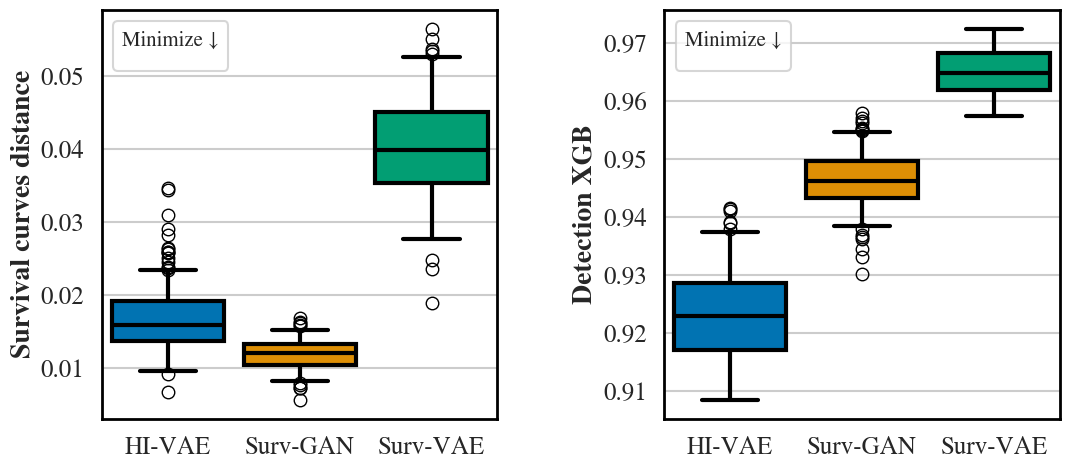

In [22]:
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

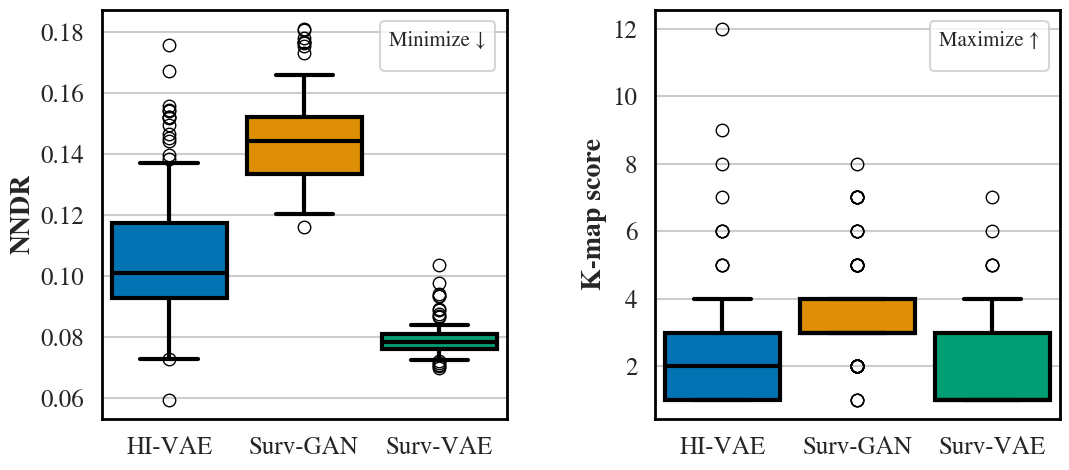

In [23]:
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics

In [24]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

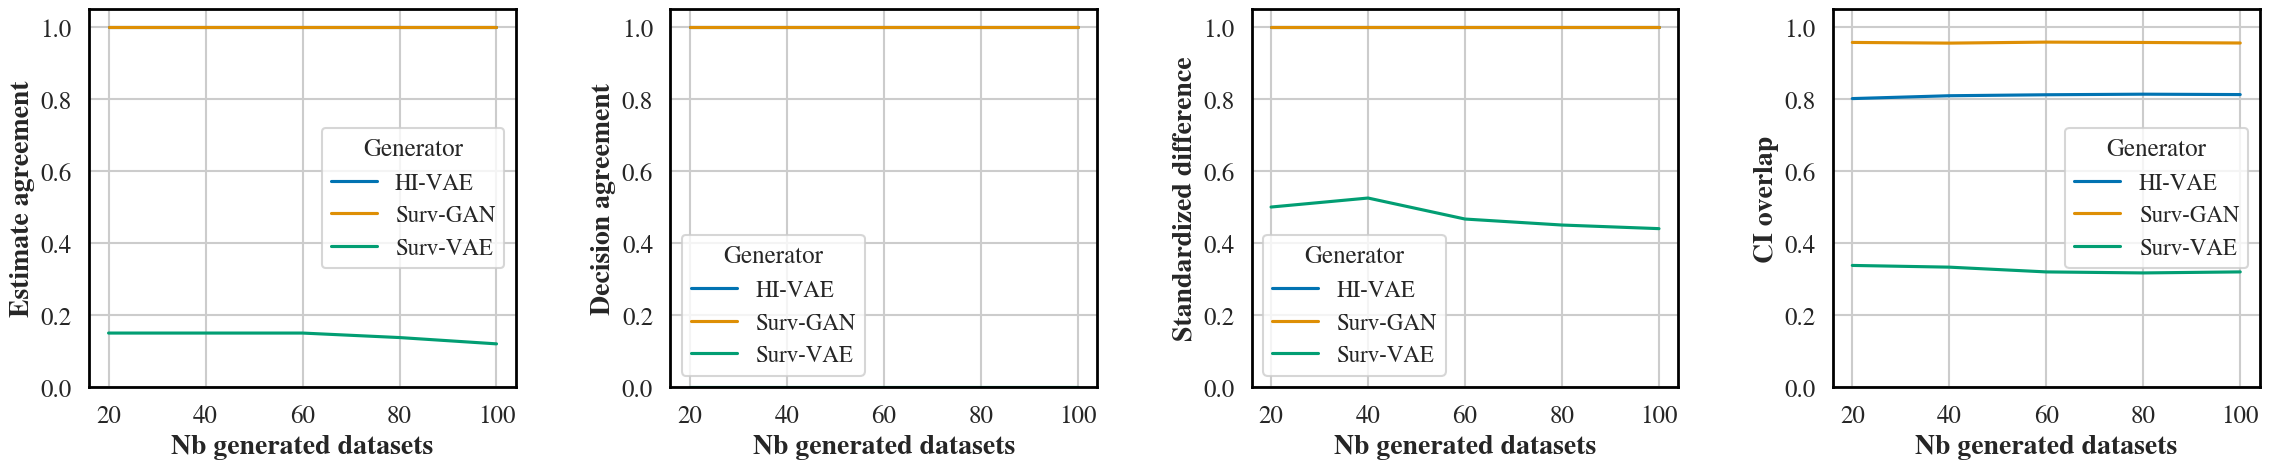

In [25]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [ ]:
# # Surv-GAN hyperparameter search: the files best_params_aids_Surv-GAN.json and optuna_study_aids_Surv-GAN.db will be created and saved

# best_params_survgan, study_survgan = generators_dict["Surv-GAN"].optuna_hyperparameter_search(data_init_control, 
#                                                                                             columns=aids_control_fnames, 
#                                                                                             target_column="censor", 
#                                                                                             time_to_event_column="time", 
#                                                                                             n_generated_sample=5, 
#                                                                                             n_splits=5,
#                                                                                             n_trials=3, 
#                                                                                             study_name="optuna_results/optuna_study_aids_Surv-GAN",)
# best_params_dict["Surv-GAN"] = best_params_survgan
# study_dict["Surv-GAN"] = study_survgan

# with open("optuna_results/best_params_aids_Surv-GAN.json", "w") as f:
#     json.dump(best_params_survgan, f)

In [ ]:
# # Surv-VAE hyperparameter search: the files best_params_aids_Surv-VAE.json and optuna_study_aids_Surv-VAE.db will be created and saved

# best_params_survae, study_survae = generators_dict["Surv-VAE"].optuna_hyperparameter_search(data_init_control, 
#                                                                                             columns=aids_control_fnames, 
#                                                                                             target_column="censor", 
#                                                                                             time_to_event_column="time", 
#                                                                                             n_generated_sample=50, 
#                                                                                             n_splits=5,
#                                                                                             n_trials=30, 
#                                                                                             study_name="optuna_results/optuna_study_aids_Surv-VAE",)
# best_params_dict["Surv-VAE"] = best_params_survae
# study_dict["Surv-VAE"] = study_survae

# with open("optuna_results/best_params_aids_Surv-VAE.json", "w") as f:
#     json.dump(best_params_survae, f)

In [ ]:
# # HI-VAE hyperparameter search: the files best_params_aids_HI-VAE.json and optuna_study_aids_HI-VAE.db will be created and saved

# T_surv = torch.Tensor(df_init_control.time)
# T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
# n_intervals = 5
# T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
# T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
# intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

# best_params_hivae, study_hivae = generators_dict["HI-VAE"].optuna_hyperparameter_search((data_init_control_encoded, intervals), 
#                                                                                         data_init_control,
#                                                                                         miss_mask_control, 
#                                                                                         true_miss_mask_control, 
#                                                                                         feat_types_file_control, 
#                                                                                         feat_types_dict, 
#                                                                                         n_generated_sample=50, 
#                                                                                         n_splits=5,
#                                                                                         n_trials=30, 
#                                                                                         columns=aids_control_fnames, 
#                                                                                         study_name="optuna_results/optuna_study_aids_HI-VAE",)
# best_params_dict["HI-VAE"] = best_params_hivae
# study_dict["HI-VAE"] = study_hivae
# with open("optuna_results/best_params_aids_HI-VAE.json", "w") as f:
#     json.dump(best_params_hivae, f)